# Poor Man's Gaussian Process Latent Variable Model

In [1]:
import numpy as np
import jax.numpy as jnp
import jax.random as jr
import poor_man_gplvm as pmg
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from scipy.interpolate import interp1d
import os
import glob
import mat73

from core import *

%matplotlib widget

c:\Users\SB13FLPC020\miniforge3\envs\pmgplvm\Lib\site-packages\h5py\__init__.py:36: UserWarning:

h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems



## Configuration

In [2]:
# ----------------------------- Config ---------------------------------

# Data paths and session info
DATA_DIR = r"z:\Homes\voerom01\HPC_transverse\HPC_transverse_M01\HPC_TR_M01_20250612"
FIG_DIR = r"z:\Homes\voerom01\HPC_transverse\HPC_transverse_M01\HPC_TR_M01_20250612\gplvmFigures"
SESSION_NAME = "HPC_TR_M01_20250612"
BASE_NAME = "HPC_TR_M01_20250612"
PROBES = [0, 1]


# Spike rate computation parameters
WINDOW_SIZE = 0.01         # s
STEP_SIZE   = 0.01       # s
USE_UNITS   = "good"       # {'all', 'good', 'mua'}


# Filtering thresholds
MIN_TOTAL_SPIKES   = 500
MIN_MEAN_RATE_HZ   = 0.01
MIN_PRESENCE_RATIO = 0.50
N_TIME_BINS        = 100    # coarse bins for presence ratio


# defining the region dictionary. Keys are probe numbers, values are dictionaries which are further mapping shanks to regions
#region_dict = {0: {0: 'CA1', 1: 'RSP', 2: 'CA3', 3: 'CA1', 4: 'RSP', 5: 'CA3', 6: 'CA1', 7: 'RSP'}, 1: {0: 'CA3', 1: 'CA1', 2: 'CA2', 3: 'A1', 4: 'S1'}, 2: {0: 'CA3', 1: 'Th', 2: 'V1', 3: 'Th', 4: 'CA1', 5: 'V1', 6: 'CA1', 7: 'V1'}} UDS
region_dict = {
    0: {0: 'CA1', 1: 'CA1', 2: 'CA1', 3: 'CA1'},
    1: {0: 'CA1', 1: 'CA1', 2: 'CA1', 3: 'CA1'},
    2: {0: 'CA1', 1: 'CA1', 2: 'CA1', 3: 'Th'}, 
    3: {0: 'CA1', 1: 'CA1', 2: 'CA1', 3: 'CA1'}
} #This is going to need to be replaced by manual unit labels....


# defining the hemisphere dictionary. Keys are probe numbers, values are 'L' or 'R' for left/right hemisphere
hemisphere_dict = {0: 'L', 1: 'L', 2: 'R', 3: 'R'}

# Create figure directory if it doesn't exist
os.makedirs(FIG_DIR, exist_ok=True)

## Loading the spike counts

In [3]:
# ---------------------------Config------------------------------------
use_mat73 = True  # Set to True if .mat files are v7.3 format


# ------------------------ Load spike rate matrices ------------------------
spike_count_matrices = {}
cell_types = {}
regions = {}
for probe in PROBES:

    if probe == 0:
        use_mat73 = True
    else:
        use_mat73 = False

        
    # Get the raw spike counts and the zscored and smoothed spike rates
    #ks_dir = os.path.join(DATA_DIR, f'Kilosort_imec{probe}_ks4')
    pattern = os.path.join(DATA_DIR, f"Kilosort*imec{probe}*")
    matches = glob.glob(pattern)
    ks_dir = matches[0]  # assuming there's only one match
    print(f"Loading spike counts from Kilosort directory: {ks_dir}")
    #spike_count_matrix, time_bins, units = compute_spike_counts(str(ks_dir), WINDOW_SIZE, STEP_SIZE, USE_UNITS, 0.0, False, adj = '_sec_adj')
    spike_count_matrix, time_bins, units = compute_spike_counts(str(ks_dir), WINDOW_SIZE, STEP_SIZE, USE_UNITS, 0.0, False, adj = '')


    # computing the filtering metrics
    total_spikes   = spike_count_matrix.sum(axis=1)         
    mean_rates   = spike_count_matrix.mean(axis=1) / WINDOW_SIZE
    presence_ratio = get_presence_ratio(spike_count_matrix, time_bins, N_TIME_BINS)

    mask = (
        (total_spikes >= MIN_TOTAL_SPIKES) &
        (mean_rates >= MIN_MEAN_RATE_HZ) &
        (presence_ratio >= MIN_PRESENCE_RATIO)
    )


    # Apply mask to spike rate matrix and unit list
    spike_count_matrix = spike_count_matrix[mask, :]
    units = [u for u, keep in zip(units, mask) if keep]
    print(f"Probe {probe}: Keeping {mask.sum()} / {mask.sum() + (~mask).sum()} units after filtering.\nspike_count_matrix shape: {spike_count_matrix.shape}\n")

    # remove units based on presence ratio
    spike_count_matrices[probe] = (spike_count_matrix, time_bins, units)


# Load the cell metrics
    cell_metrics_file = os.path.join(DATA_DIR, f'{BASE_NAME}_imec{probe}.cell_metrics.cellinfo.mat')
    print(f"Loading cell metrics from: {cell_metrics_file}")
    if use_mat73:
        cell_metrics_data = mat73.loadmat(cell_metrics_file)
        cm = cell_metrics_data['cell_metrics']
        cell_type = np.array(cm['putativeCellType'])
        shank_ids = np.array(cm['shankID'])
        CluIDs = np.array(cm['cluID'])
    else:
        cm = loadmat(cell_metrics_file)['cell_metrics']
        cell_type = cm['putativeCellType'][0, 0]
        shank_ids = cm['shankID'][0, 0]
        CluIDs = cm['cluID'][0, 0]

    # Ensure 1D arrays
    CluIDs = np.asarray(CluIDs).reshape(-1)
    shank_ids = np.asarray(shank_ids).reshape(-1)

    # flatten cell_type and turn into strings
    cell_type = np.array([
        ct[0] if isinstance(ct, (np.ndarray, list)) else ct
        for ct in np.asarray(cell_type).reshape(-1)
    ])

    # ------------------ ALIGN USING INTERSECTION ------------------
    units = np.asarray(units)  # ensure ndarray for indexing
    print(f"cell_metrics has {len(CluIDs)} entries; spike-count units: {len(units)}")

    # map cluID -> index into cell_metrics arrays
    id_to_idx = {int(cid): i for i, cid in enumerate(CluIDs)}

    keep_rows = []
    aligned_cell_type = []
    aligned_shank_ids = []
    aligned_units = []

    for row, uid in enumerate(units):
        idx = id_to_idx.get(int(uid), None)
        if idx is None:
            # this unit has no cell_metrics entry; drop it
            print(f"Warning: Unit ID {uid} not found in cell_metrics; dropping from analysis.")
            continue
        aligned_units.append(uid)
        aligned_cell_type.append(cell_type[idx])
        aligned_shank_ids.append(shank_ids[idx])
        keep_rows.append(row)

    keep_rows = np.asarray(keep_rows, dtype=int)

    # apply to spike_count_matrix and units
    spike_count_matrix = spike_count_matrix[keep_rows, :]
    units = np.asarray(aligned_units)
    cell_type = np.asarray(aligned_cell_type)
    shank_ids = np.asarray(aligned_shank_ids)

    print(f"After alignment: {len(units)} units remain with cell_metrics info.")

    # store per-probe results
    spike_count_matrices[probe] = (spike_count_matrix, time_bins, units)
    cell_types[probe] = cell_type
    regions[probe] = np.array([region_dict[probe][sid - 1] for sid in shank_ids])  # shank IDs are 1-based
    # --------------------------------------------------------------

Loading spike counts from Kilosort directory: z:\Homes\voerom01\HPC_transverse\HPC_transverse_M01\HPC_TR_M01_20250612\Kilosort_25_2025-06-27_001526_imec0
spike times path: z:\Homes\voerom01\HPC_transverse\HPC_transverse_M01\HPC_TR_M01_20250612\Kilosort_25_2025-06-27_001526_imec0\spike_times.npy
spike clusters path: z:\Homes\voerom01\HPC_transverse\HPC_transverse_M01\HPC_TR_M01_20250612\Kilosort_25_2025-06-27_001526_imec0\spike_clusters.npy
Probe 0: Keeping 142 / 142 units after filtering.
spike_count_matrix shape: (142, 1996986)

Loading cell metrics from: z:\Homes\voerom01\HPC_transverse\HPC_transverse_M01\HPC_TR_M01_20250612\HPC_TR_M01_20250612_imec0.cell_metrics.cellinfo.mat
cell_metrics has 122 entries; spike-count units: 142
After alignment: 112 units remain with cell_metrics info.
Loading spike counts from Kilosort directory: z:\Homes\voerom01\HPC_transverse\HPC_transverse_M01\HPC_TR_M01_20250612\Kilosort_25_2025-06-29_040238_imec1
spike times path: z:\Homes\voerom01\HPC_transver

## Extracting the tracking data

In [ ]:
use_position = 'x'  # 'x', 'y', or 'z'

# Loading the manually extracted TTL times
manual_ttl_file = os.path.join(DATA_DIR, 'manual_ttl_extraction.csv')
manual_ttls_df = pd.read_csv(manual_ttl_file)
ttls = manual_ttls_df['ttl_times_sec'].values

# Loadding in the tracking data
tracking_file = os.path.join(DATA_DIR, "Bilat_R02_20251106_linear_maze_000.csv")
tracking_data = np.genfromtxt(tracking_file, delimiter=",", skip_header=7)
frames = tracking_data[:,0]
print(f'Number of frames: {len(frames)}')
print(f'first row of tracking data: {tracking_data[0,:]}')


# Sometimes there are a few more frames after the last TTL or more TTLs than frames. We will trim the data to the shortest length.
if len(frames) < len(ttls):
    print(f'Trimming TTLs from {len(ttls)} to {len(frames)}')
    ttls = ttls[:len(frames)]
    tracking_data = tracking_data[:len(frames),:]
elif len(frames) > len(ttls):
    print(f'Trimming frames from {len(frames)} to {len(ttls)}')
    frames = frames[:len(ttls)]
    tracking_data = tracking_data[:len(ttls),:]

# printing the start and end times
print(f'Tracking start time: {ttls[0]:.3f} s, end time: {ttls[-1]:.3f} s, duration: {ttls[-1]-ttls[0]:.3f} s')


# fill missing values or nan with linear interpolation
for i in range(tracking_data.shape[1]):
    col = tracking_data[:,i]
    nans = np.isnan(col)
    if np.any(nans):
        not_nans = ~nans
        interp_func_col = interp1d(frames[not_nans], col[not_nans], bounds_error=False, fill_value="extrapolate")
        col[nans] = interp_func_col(frames[nans])
        tracking_data[:,i] = col

# extract x, y, z positions and rotations
x_rotations = tracking_data[:,2]
y_rotations = tracking_data[:,3]
z_rotations = tracking_data[:,4]
w_rotations = tracking_data[:,5]
x_positions = tracking_data[:,6]
y_positions = tracking_data[:,7]
z_positions = tracking_data[:,8]

# setting the pos_raw to the selected position axis
if use_position == 'x':
    pos_raw = x_positions
elif use_position == 'y':
    pos_raw = y_positions
elif use_position == 'z':
    pos_raw = z_positions

# getting the speed
speed = np.abs(np.gradient(pos_raw) / np.gradient(ttls))  # speed in m/s

# Plotting the tracking data
fig, axs = plt.subplots(2, 2, figsize=(15,8))

sns.lineplot(ax=axs[0,0], x=ttls, y=x_positions, label='X Position')
sns.lineplot(ax=axs[0,0], x=ttls, y=y_positions, label='Y Position')
sns.lineplot(ax=axs[0,0], x=ttls, y=z_positions, label='Z Position')
axs[0,0].set_ylabel('Position')
axs[0,0].set_title('Tracking Data - Positions')

sns.lineplot(ax=axs[1, 0], x=ttls, y=x_rotations, label='X Rotation')
sns.lineplot(ax=axs[1, 0], x=ttls, y=y_rotations, label='Y Rotation')
sns.lineplot(ax=axs[1, 0], x=ttls, y=z_rotations, label='Z Rotation')
sns.lineplot(ax=axs[1, 0], x=ttls, y=w_rotations, label='W Rotation')
axs[1, 0].set_xlabel('Seconds')
axs[1, 0].set_ylabel('Rotation')
axs[1, 0].set_title('Tracking Data - Rotations')

sns.histplot(ax=axs[0, 1], x=pos_raw, bins=100)
axs[0, 1].set_xlabel('Position (meters)')
axs[0, 1].set_ylabel('Count')
axs[0, 1].set_title(f'{use_position.upper()} Position Histogram')

sns.histplot(ax=axs[1, 1], x=speed[speed < np.percentile(speed, 99)], bins=100)
axs[1, 1].set_xlabel('Speed (m/s)')
axs[1, 1].set_ylabel('Count')
axs[1, 1].set_title('Speed Histogram')
axs[1, 1].axvline(x = np.median(speed), color='red', linestyle='--', label=f'Median Speed: {np.median(speed):.2f} m/s')
axs[1, 1].legend()
sns.despine()
plt.tight_layout()
#plt.savefig(os.path.join(FIG_DIR, "tracking_data.png"), dpi=300)
plt.show()


### Bining position

In [ ]:
N_SPATIAL_BINS = 25
POS_MIN = -0.5
POS_MAX = 0.7

# compute the spatial bin edges
bin_edges = np.linspace(POS_MIN, POS_MAX, N_SPATIAL_BINS + 1)

# Creating interpolation function for position
pos_interp_func = interp1d(ttls, pos_raw, kind = 'linear', bounds_error=False, fill_value=np.nan)

# getting reference time from probe with shortest timebins
tb_ref = None
for probe in PROBES:
    _, tb_probe, _ = spike_count_matrices[probe]
    if tb_ref is None:
        tb_ref = tb_probe
    elif len(tb_probe) < len(tb_ref):
        tb_ref = tb_probe

# Build canonical masks on the *reference* tb_ref
pos_ref = pos_interp_func(tb_ref)
valid_ttl  = (tb_ref >= np.min(ttls)) & (tb_ref <= np.max(ttls))
print(f'number of valid TTL timebins: {valid_ttl.sum()} / {len(tb_ref)}')
finite_pos = np.isfinite(pos_ref)
print(f'number of finite position timebins: {finite_pos.sum()} / {len(tb_ref)}')
# filtering when slower than median speed
speed = np.abs(np.gradient(pos_ref) / np.gradient(tb_ref))
speed_mask = (speed > 0.03)
print(f'number of timebins with speed > 0.03: {speed_mask.sum()} / {len(speed)}')

mask = valid_ttl & finite_pos

# digitize positions into spatial bins
pos_bins = np.digitize(pos_ref[mask], bin_edges) - 1  # bins are 0-indexed



### Aligning neural data to position

In [4]:
# ------------------------ Plotting spike raster for each hemisphere and the binarized positions------------------------
REGIONS = ['CA1']
UNIT_TYPES = ['Pyramidal Cell']

# preparing the lists to collect spike rates
selected_spike_counts_L = []
selected_spike_counts_R = []

# making a fake timebase ref since no position info is available
no_position = True
if no_position:
    start_time = 0.0
    # getting the end time from the shortest probe
    end_time = None
    for probe in PROBES:
        _, tb_probe, _ = spike_count_matrices[probe]
        if end_time is None:
            end_time = np.max(tb_probe)
        elif np.max(tb_probe) < end_time:
            end_time = np.max(tb_probe)
    tb_ref = np.arange(start_time, end_time, STEP_SIZE)

    # setting the mask to all timebins
    mask = np.ones_like(tb_ref, dtype=bool)

    # making constant position bins
    pos_bins = np.zeros(np.sum(mask), dtype=int)

# looping over probes to collect spike rates
for probe in PROBES:

    spike_count_matrix, probe_times, units = spike_count_matrices[probe]  # (n_units, n_timebins)
    hemisphere = hemisphere_dict[probe]


    # cropping the probe times to match the reference timebins
    print(f'Probe {probe} timebins length {len(probe_times)}: reference timebins length {len(tb_ref)}')
    start_time, end_time = np.min(tb_ref), np.max(tb_ref)
    valid_time_probe = (probe_times >= start_time) & (probe_times <= end_time)

    # check if all time values are now equal
    probe_times = probe_times[valid_time_probe]
    spike_count_matrix = spike_count_matrix[:, valid_time_probe]
        
    if np.allclose(probe_times, tb_ref, rtol=0, atol=1e-9):
        print(f'Probe {probe} timebins successfully matched to reference timebins after cropping.')
        print(f'sum of differences: {np.sum(probe_times - tb_ref)}\n')
    else:
        raise ValueError(f'Probe {probe} timebins do not match reference timebins after cropping. Lengths: {len(probe_times)} vs {len(tb_ref)}')


    # filtering out timebins outside the TTL range and speed threshold
    spike_counts = spike_count_matrix[:, mask]



    # getting cell types and regions for the current probe
    ct_probe = np.asarray(cell_types[probe])                    
    rgn_arr = regions[probe]                                   

    # select units from the selected regions
    unit_sel = np.where(
        (np.isin(ct_probe, UNIT_TYPES)) &
        (np.isin(rgn_arr, REGIONS))
    )[0]
    if unit_sel.size == 0:
        continue

    if hemisphere == 'L':
        selected_spike_counts_L.append(spike_counts[unit_sel, :])
    elif hemisphere == 'R':
        selected_spike_counts_R.append(spike_counts[unit_sel, :])
    else:
        raise ValueError(f'Unknown hemisphere {hemisphere} for probe {probe}')

# concatenating the selected spike rates across probes
if (len(selected_spike_counts_L) == 0 and len(selected_spike_counts_R) == 0):
    raise RuntimeError("No units found for the chosen regions after filtering.")

spike_counts_concat_L = np.vstack(selected_spike_counts_L) if len(selected_spike_counts_L) > 0 else np.empty((0, 0))
spike_counts_concat_R = np.vstack(selected_spike_counts_R) if len(selected_spike_counts_R) > 0 else np.empty((0, 0))

# sort the units based on correlation
sorted_spike_counts_concat_L = sort_units(spike_counts_concat_L, mode='corr')
sorted_spike_counts_concat_R = sort_units(spike_counts_concat_R, mode='corr')

# getting the time vector in seconds
times = tb_ref[mask] - tb_ref[0]

print(f'sorted_counts_concat_L shape: {sorted_spike_counts_concat_L.shape}')
print(f'sorted_counts_concat_R shape: {sorted_spike_counts_concat_R.shape}')
print(f'pos_bins shape: {pos_bins.shape}')
#print(f'pos_ref shape: {pos_ref.shape}')
print(f'times shape: {times.shape}')

Probe 0 timebins length 1996986: reference timebins length 1996986
Probe 0 timebins successfully matched to reference timebins after cropping.
sum of differences: 0.0

Probe 1 timebins length 1996986: reference timebins length 1996986
Probe 1 timebins successfully matched to reference timebins after cropping.
sum of differences: 0.0

sorted_counts_concat_L shape: (98, 1996986)
sorted_counts_concat_R shape: (0, 0)
pos_bins shape: (1996986,)
times shape: (1996986,)


In [ ]:
START = len(times) // 2
STOP = len(times) // 2 + 2000

# indices within the sliced segment (0 .. STOP-START-1)
x_idx = np.arange(STOP - START)

fig, axs = plt.subplots(3, 1, figsize=(20, 8), sharex=True)

# --- Left hemisphere raster ---
sns.heatmap(
    ax=axs[0],
    data=sorted_spike_counts_concat_L[:, START:STOP],
    cmap='viridis',
    cbar=False
)
axs[0].set_ylabel('Unit')
axs[0].set_title('Spike Raster - Left Hemisphere')
axs[0].set_yticks(np.arange(0, sorted_spike_counts_concat_L.shape[0], 25))
axs[0].set_yticklabels(np.arange(0, sorted_spike_counts_concat_L.shape[0], 25))

# --- Right hemisphere raster ---
sns.heatmap(
    ax=axs[1],
    data=sorted_spike_counts_concat_R[:, START:STOP],
    cmap='viridis',
    cbar=False
)
axs[1].set_ylabel('Unit')
axs[1].set_title('Spike Raster - Right Hemisphere')
axs[1].set_yticks(np.arange(0, sorted_spike_counts_concat_R.shape[0], 25))
axs[1].set_yticklabels(np.arange(0, sorted_spike_counts_concat_R.shape[0], 25))

# --- Position trace ---
# IMPORTANT: use the same x_idx as x, not times[]
sns.lineplot(
    ax=axs[2],
    x=x_idx,
    y=pos_bins[START:STOP],
    color='blue'
)
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Position Bin')
axs[2].set_title('Position Over Time')

axs[2].set_yticks(np.arange(0, N_SPATIAL_BINS, 10))
axs[2].set_yticklabels(np.arange(0, N_SPATIAL_BINS, 10))

# Now set ticks in index space, but label them with seconds
if STOP == -1:
    tick_idx = np.arange(0, len(times) - START, 500)  # index within the window
    tick_labels = np.round(times[START::500], 1)
else:
    tick_idx = np.arange(0, STOP - START, 500)  # index within the window
    tick_labels = np.round(times[START:STOP:500], 1)

axs[2].set_xticks(tick_idx)
axs[2].set_xticklabels(tick_labels)

sns.despine()
plt.tight_layout()
plt.show()

## Fitting the model

In [5]:
# define the models for the left and right hemispheres
N_SPATIAL_BINS = 100
model_l=pmg.PoissonGPLVMJump1D(sorted_spike_counts_concat_L.shape[0], n_latent_bin=N_SPATIAL_BINS + 1, movement_variance=1, tuning_lengthscale=1)
#model_r=pmg.PoissonGPLVMJump1D(sorted_spike_counts_concat_R.shape[0], n_latent_bin=N_SPATIAL_BINS + 1, movement_variance=1, tuning_lengthscale=1)


# randomize the position bins for training
pos_bins = np.random.randint(0, N_SPATIAL_BINS + 1, size=sorted_spike_counts_concat_L.shape[1])

#print(pos_bins.shape)
print(sorted_spike_counts_concat_L.shape)

# getting the log posterior init
log_posterior_init = np.zeros((sorted_spike_counts_concat_L.shape[1], N_SPATIAL_BINS + 1 ))

print(log_posterior_init.shape)
for t in range(sorted_spike_counts_concat_L.shape[1]):
    log_posterior_init[t, pos_bins[t]] += 1

# adding a small value to avoid log(0)
log_posterior_init += 1e-6

#normalizing so sums to 1
log_posterior_init /= log_posterior_init.sum(axis=1, keepdims=True)

# converting to log space
log_posterior_init = np.log(log_posterior_init)

print(f'log_posterior_init shape: {log_posterior_init.shape}')





(98, 1996986)
(1996986, 101)
log_posterior_init shape: (1996986, 101)


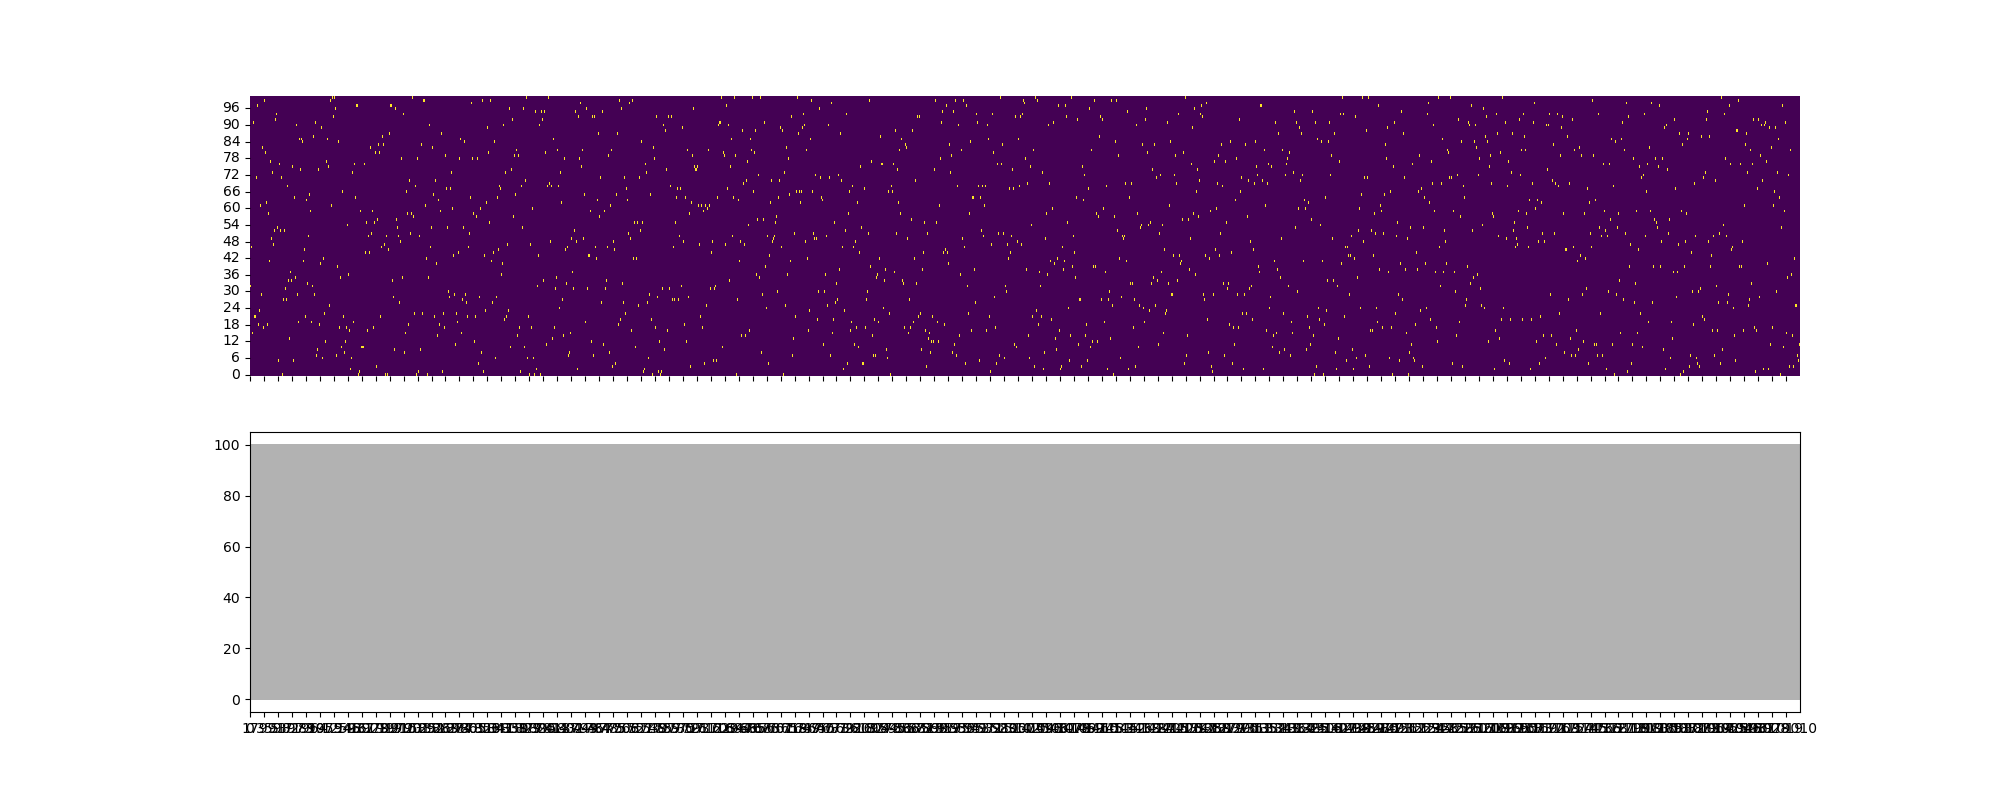

In [6]:
# plotting the log posterior init
fig, axs = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
sns.heatmap(ax=axs[0], data=log_posterior_init.T, cmap='viridis', cbar=False)
axs[0].invert_yaxis()
axs[1].plot(pos_bins, color='k', linewidth=1, alpha = 0.3)
plt.show()


In [7]:
# fitting the models
#em_res_r = model_r.fit_em(sorted_spike_counts_concat_R.T, key=jr.PRNGKey(3), n_iter=20, log_posterior_init=None, ma_neuron=None, ma_latent=None, n_time_per_chunk=10000)
em_res_l = model_l.fit_em(sorted_spike_counts_concat_L.T, key=jr.PRNGKey(3), n_iter=25, log_posterior_init=None, ma_neuron=None, ma_latent=None, n_time_per_chunk=10000)

c:\Users\SB13FLPC020\miniforge3\envs\pmgplvm\Lib\site-packages\jax\_src\abstract_arrays.py:68: RuntimeWarning:

overflow encountered in cast

c:\Users\SB13FLPC020\miniforge3\envs\pmgplvm\Lib\site-packages\jax\_src\interpreters\xla.py:158: RuntimeWarning:

overflow encountered in cast

EM:   0%|          | 0/25 [00:00<?, ?it/s]c:\Users\SB13FLPC020\miniforge3\envs\pmgplvm\Lib\site-packages\jax\_src\abstract_arrays.py:68: RuntimeWarning:

overflow encountered in cast

c:\Users\SB13FLPC020\miniforge3\envs\pmgplvm\Lib\site-packages\jax\_src\lax\lax.py:2476: RuntimeWarning:

overflow encountered in cast

EM: 100%|██████████| 25/25 [16:37:49<00:00, 2394.79s/it]  


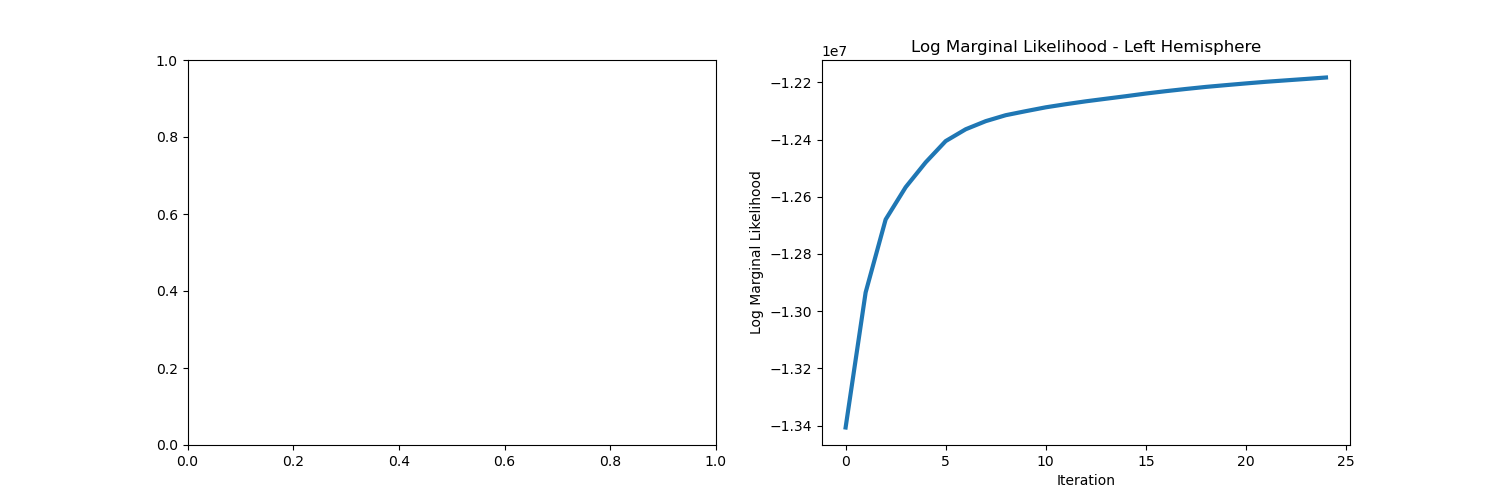

In [8]:
# monitor training
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
#axs[0].plot(em_res_r['log_marginal_l'], linewidth=3)
#axs[0].set_xlabel('Iteration')
#axs[0].set_ylabel('Log Marginal Likelihood')
#axs[0].set_title('Log Marginal Likelihood - Right Hemisphere')
axs[1].plot(em_res_l['log_marginal_l'], linewidth=3)
axs[1].set_xlabel('Iteration') 
axs[1].set_ylabel('Log Marginal Likelihood')
axs[1].set_title('Log Marginal Likelihood - Left Hemisphere')
plt.show()

## Testing the model

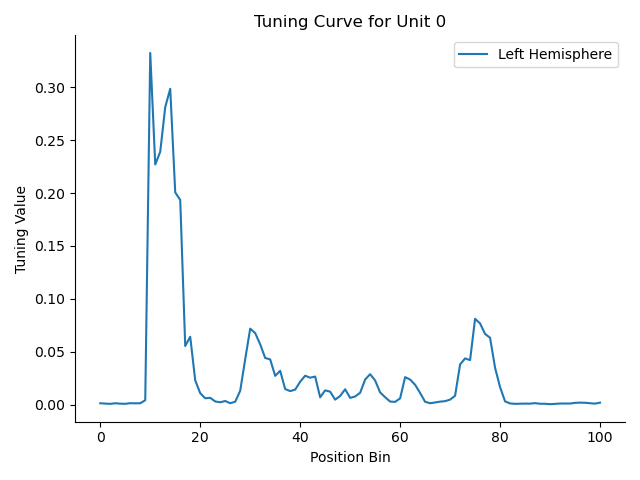

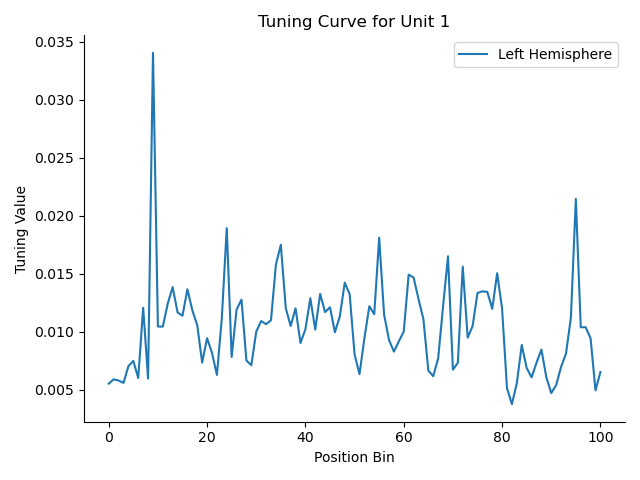

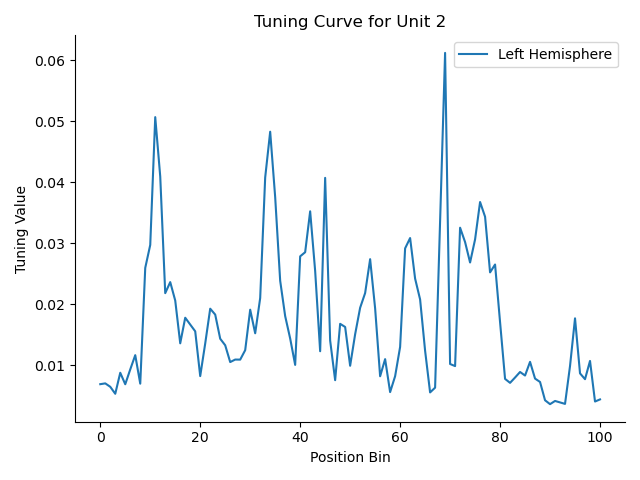

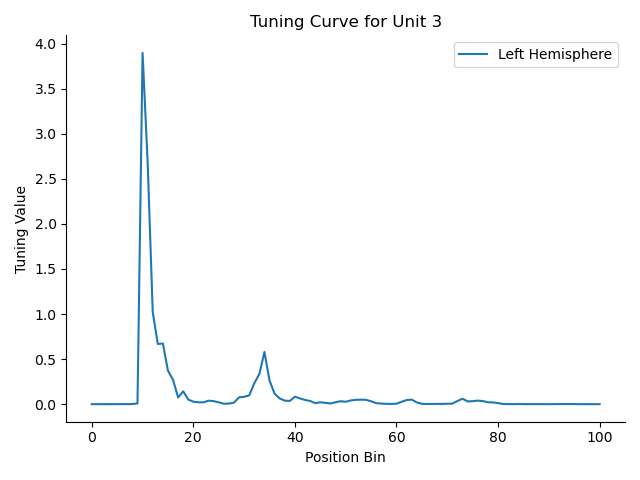

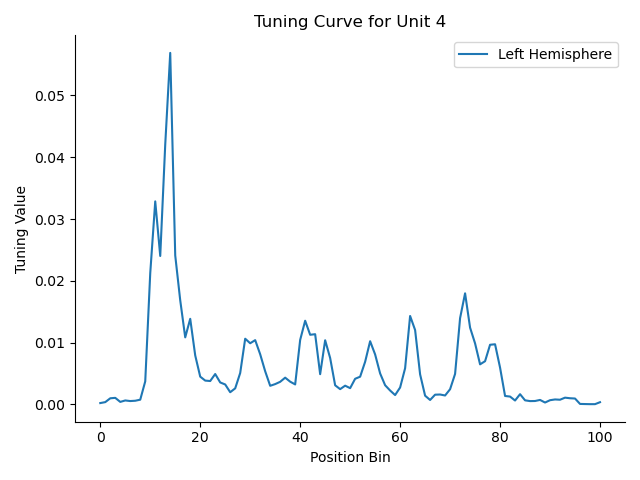

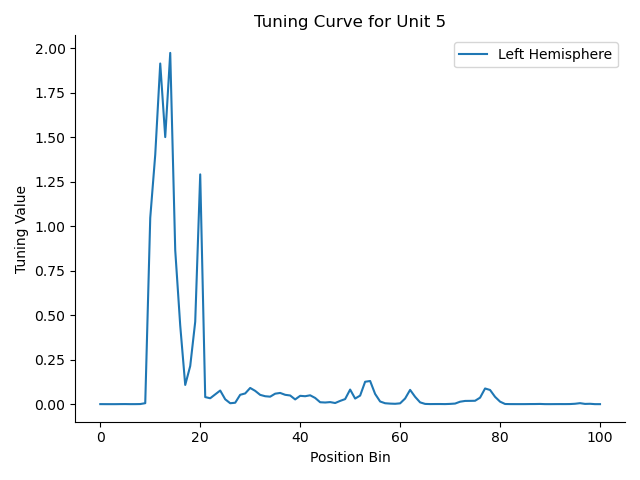

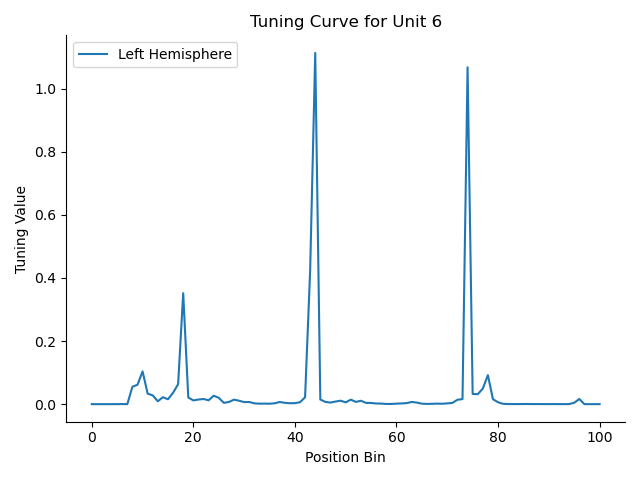

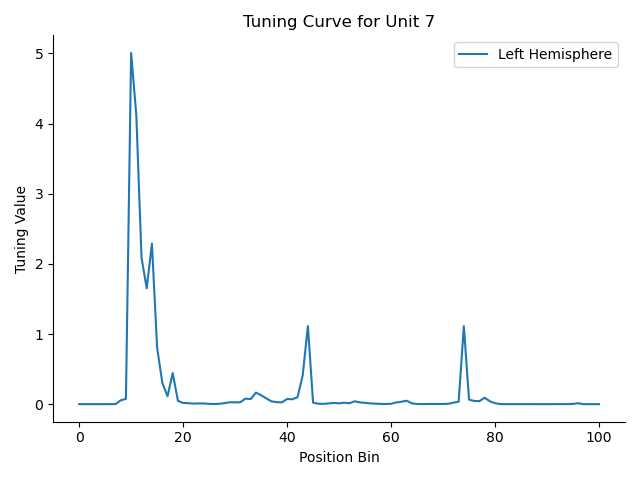

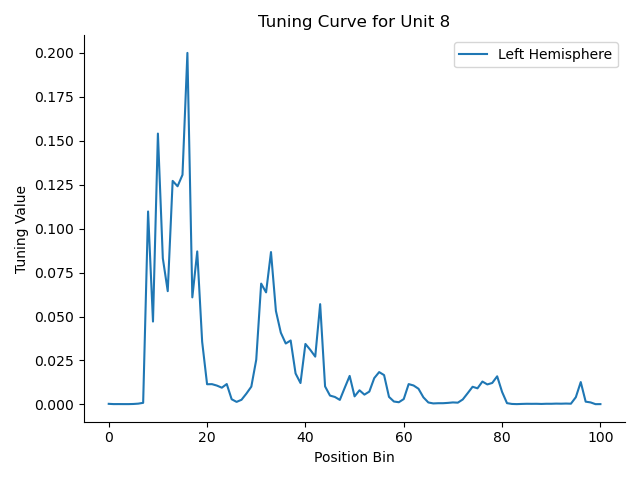

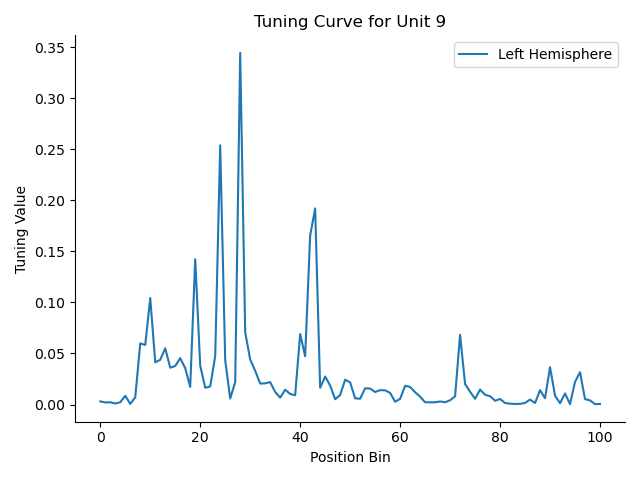

In [9]:
#tuning_curves_r = model_r.tuning
tuning_curves_l = model_l.tuning
for neuron in range(10):
    plt.figure()
    #plt.plot(tuning_curves_r[:, neuron], label='Right Hemisphere')
    plt.plot(tuning_curves_l[:, neuron], label='Left Hemisphere')
    plt.title(f'Tuning Curve for Unit {neuron}')
    plt.xlabel('Position Bin')
    plt.ylabel('Tuning Value')
    plt.legend()
    sns.despine()
    plt.tight_layout()
    plt.show()

In [10]:
#decode_res_r = model_r.decode_latent(sorted_spike_counts_concat_R.T)
decode_res_l = model_l.decode_latent(sorted_spike_counts_concat_L.T)

#latent_posteriors_r = decode_res_r['posterior_latent_marg']
#jump_prob_r = decode_res_r['posterior_dynamics_marg'][:,1]
#continuous_prob_r = decode_res_r['posterior_dynamics_marg'][:,0]

#print(f'latent_posteriors_r shape: {latent_posteriors_r.shape}')
#print(f'jump_prob_r shape: {jump_prob_r.shape}')
#print(f'continuous_prob_r shape: {continuous_prob_r.shape}')


latent_posteriors_l = decode_res_l['posterior_latent_marg']
jump_prob_l = decode_res_l['posterior_dynamics_marg'][:,1]
continuous_prob_l = decode_res_l['posterior_dynamics_marg'][:,0]

print(f'latent_posteriors_l shape: {latent_posteriors_l.shape}')
print(f'jump_prob_l shape: {jump_prob_l.shape}')
print(f'continuous_prob_l shape: {continuous_prob_l.shape}')



latent_posteriors_l shape: (1996986, 101)
jump_prob_l shape: (1996986,)
continuous_prob_l shape: (1996986,)


In [11]:
# making a time vector in seconds
time_array = np.arange(latent_posteriors_l.shape[0]) * STEP_SIZE
print(f'time_array shape: {time_array.shape}')
print(time_array)

time_array shape: (1996986,)
[0.000000e+00 1.000000e-02 2.000000e-02 ... 1.996983e+04 1.996984e+04
 1.996985e+04]


In [12]:
# save the posterior results
np.savez_compressed(
    os.path.join(DATA_DIR, 'gplvm', f'{SESSION_NAME}_gplvm_posteriors_100bins.npz'),
    latent_posteriors=latent_posteriors_l,
    jump_prob=jump_prob_l,
    continuous_prob=continuous_prob_l,
    time_array=time_array

)


In [13]:
import numpy as np
from scipy.io import savemat

fn = os.path.join(DATA_DIR, 'gplvm', f'{SESSION_NAME}_gplvm_posteriors_100bins.npz')

# load npz
data = np.load(fn)

# convert to .mat
savemat(os.path.join(DATA_DIR, 'gplvm', f'{SESSION_NAME}_gplvm_posteriors_100bins.mat'), {
    'latent_posteriors': data['latent_posteriors'],
    'jump_prob': data['jump_prob'],
    'continuous_prob': data['continuous_prob'],
    'time_seconds': data['time_array']
})

In [ ]:
# save the posterior results
np.savez_compressed(
    os.path.join(DATA_DIR, 'gplvm', f'{SESSION_NAME}_gplvm_posteriors_100bins.npz'),
    latent_posteriors_r=latent_posteriors_r,
    jump_prob_r=jump_prob_r,
    continuous_prob_r=continuous_prob_r,
    latent_posteriors_l=latent_posteriors_l,
    jump_prob_l=jump_prob_l,
    continuous_prob_l=continuous_prob_l,
    time_array=time_array

)





In [ ]:
import numpy as np
from scipy.io import savemat

fn = r"Z:\Homes\voerom01\Bilat_HPC\Bilat_R02\Bilat_R02_20251113\gplvm\pre_sleep_g0_gplvm_posteriors_100bins.npz"

# load npz
data = np.load(fn)

# convert to .mat
savemat(os.path.join(DATA_DIR, 'gplvm', f'{SESSION_NAME}_gplvm_posteriors_100bins.mat'), {
    'latent_posteriors_r': data['latent_posteriors_r'],
    'jump_prob_r': data['jump_prob_r'],
    'continuous_prob_r': data['continuous_prob_r'],
    'latent_posteriors_l': data['latent_posteriors_l'],
    'jump_prob_l': data['jump_prob_l'],
    'continuous_prob_l': data['continuous_prob_l'],
    'time_seconds': data['time_array']
})

In [ ]:
START = 0 #seconds
STOP = np.max(time_array) # seconds


# start times at 0
min_times = np.min(times)
times -= min_times

#converting start and stop to indeices
START = int((START - min_times) / (tb_ref[1] - tb_ref[0]))
STOP = int((STOP - min_times) / (tb_ref[1] - tb_ref[0]))

# plotting the latent posteriors and the jump probabilities
fig, axs = plt.subplots(3, 1, figsize=(20, 8), sharex=True, gridspec_kw={'height_ratios': [3, 3, 1]})
sns.heatmap(ax=axs[0], data=latent_posteriors_r[START:STOP, :].T, cmap='viridis', cbar=False)
axs[0].set_ylabel('Latent State')
axs[0].set_title('Latent Posterior Distribution - Right Hemisphere')


sns.heatmap(ax=axs[1], data=latent_posteriors_l[START:STOP, :].T, cmap='viridis', cbar=False)
axs[1].set_ylabel('Latent State')
axs[1].set_title('Latent Posterior Distribution - Left Hemisphere')
# flipping the y-axis to match the position trace
axs[0].invert_yaxis()
axs[1].invert_yaxis()


# --- Position trace ---
sns.lineplot(ax=axs[2], x=np.arange(STOP-START), y=pos_bins[START:STOP], color='blue')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Position Bin')
axs[2].set_title('Position Over Time')

# setting x ticks to seconds
tick_idx = np.arange(0, STOP-START, 1000)  # index within the window
tick_labels = times[START:STOP:1000].astype(int)
axs[2].set_xticks(tick_idx)
axs[2].set_xticklabels(tick_labels)


#axs[3].plot(jump_prob_r[START:STOP], label='Right Hemisphere')
#axs[3].plot(jump_prob_l[START:STOP], label='Left Hemisphere')
#axs[3].legend()


sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
START = 0 #seconds
STOP = np.max(time_array) # seconds


# start times at 0
min_times = np.min(times)
times -= min_times

#converting start and stop to indeices
START = int((START - min_times) / (tb_ref[1] - tb_ref[0]))
STOP = int((STOP - min_times) / (tb_ref[1] - tb_ref[0]))

# plotting the latent posteriors and the jump probabilities
fig, axs = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
sns.heatmap(ax=axs[0], data=latent_posteriors_r[START:STOP, :].T, cmap='viridis', cbar=False)
axs[0].set_ylabel('Latent State')
axs[0].set_title('Latent Posterior Distribution - Right Hemisphere')


sns.heatmap(ax=axs[1], data=latent_posteriors_l[START:STOP, :].T, cmap='viridis', cbar=False)
axs[1].set_ylabel('Latent State')
axs[1].set_title('Latent Posterior Distribution - Left Hemisphere')
# flipping the y-axis to match the position trace
axs[0].invert_yaxis()
axs[1].invert_yaxis()



# creating x axis with 20 values in seconds
axs[1].set_xticks(np.linspace(0, STOP-START, 20))
axs[1].set_xticklabels(np.round(np.linspace(0, times[STOP], 20), 0).astype(int))
axs[1].set_xlabel('Time (s)')



sns.despine()
plt.tight_layout()
plt.show()

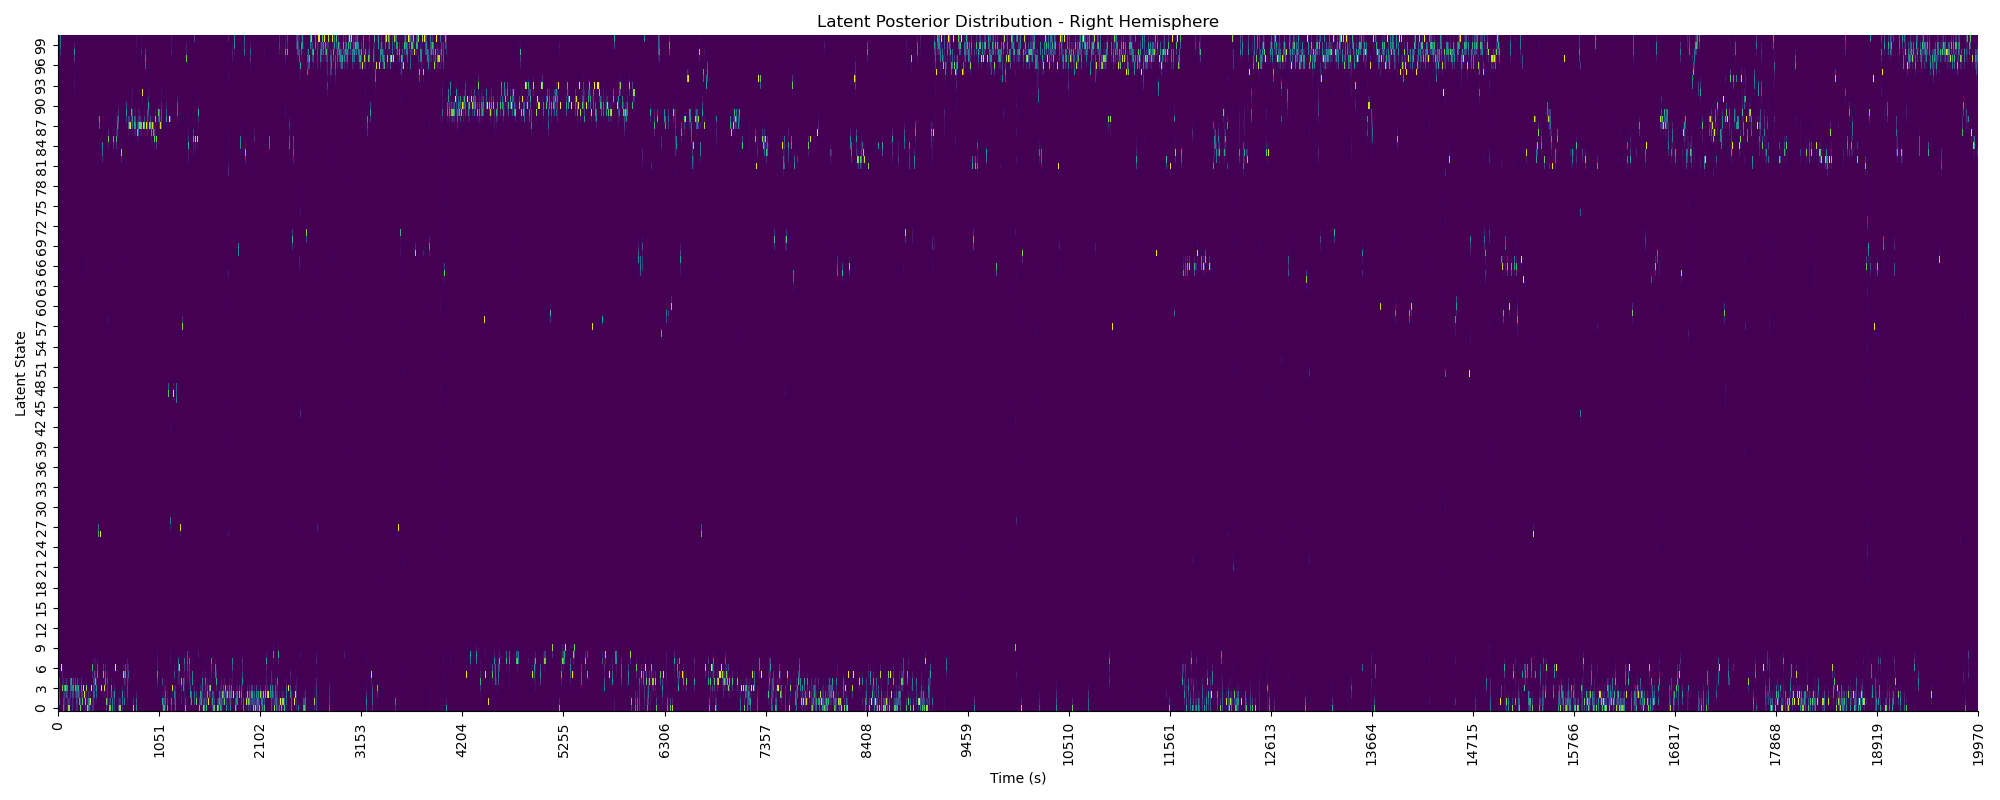

In [14]:
START = 0 #seconds
STOP = np.max(time_array) # seconds


# start times at 0
min_times = np.min(times)
times -= min_times

#converting start and stop to indeices
START = int((START - min_times) / (tb_ref[1] - tb_ref[0]))
STOP = int((STOP - min_times) / (tb_ref[1] - tb_ref[0]))

# plotting the latent posteriors and the jump probabilities
plt.figure(figsize=(20, 8))
sns.heatmap(data=latent_posteriors_l[START:STOP, :].T, cmap='viridis', cbar=False)
plt.ylabel('Latent State')
plt.title('Latent Posterior Distribution - Right Hemisphere')

# flipping the y-axis to match the position trace
plt.gca().invert_yaxis()


# creating x axis with 20 values in seconds
plt.xticks(np.linspace(0, STOP-START, 20))
plt.gca().set_xticklabels(np.round(np.linspace(0, times[STOP], 20), 0).astype(int))
plt.xlabel('Time (s)')



sns.despine()
plt.tight_layout()
plt.show()